# Neural Nets (NN)

Подключаем библиотеки и устанавливаем seed.

In [90]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

random.seed(42)

Считываем набор данных electricity-normalized.

Эти данные были получены с рынка электроэнергии австралийского Нового Южного Уэльса. На этом рынке цены не фиксированы и зависят от спроса и предложения на рынке. Они устанавливаются каждые пять минут. Передача электроэнергии в / из соседнего штата Виктория была осуществлена, чтобы смягчить колебания.

Набор данных (первоначально названный ELEC2) содержит 45 312 экземпляров, датированных с 7 мая 1996 г. по 5 декабря 1998 г. Каждый пример набора данных относится к периоду в 30 минут, т. е. имеется 48 экземпляров для каждого периода времени в один день. Каждый пример в наборе данных имеет 5 полей, день недели, отметку времени, спрос на электроэнергию в Новом Южном Уэльсе, спрос на электроэнергию в Виктории, запланированную передачу электроэнергии между штатами и метку класса. Метка класса определяет изменение цены (ВВЕРХ или ВНИЗ) в Новом Южном Уэльсе относительно скользящей средней за последние 24 часа (и устраняет влияние долгосрочных ценовых трендов).

In [91]:
df_full = pd.read_csv('electricity-normalized.csv')

Удалим столбец "date", выведем первые 5 строк и размеры набора.

date: дата с 7 мая 1996 г. по 5 декабря 1998 г. Здесь нормализовано значение от 0 до 1.
day: день недели (1-7)
period: время измерения (1-48) с получасовыми интервалами в течение 24 часов. Здесь нормализовано между 0 и 1
nswprice: цена на электроэнергию в Новом Южном Уэльсе, нормализованная от 0 до 1.
nswdemand: спрос на электроэнергию в Новом Южном Уэльсе, нормализованный от 0 до 1.
vicprice: цена на электроэнергию штата Виктория, нормализованная между 0 и 1.
vicdemand: потребность Виктории в электроэнергии, нормализованная между 0 и 1.
transfer: запланированная передача электроэнергии между обоими состояниями, нормализованная между 0 и 1.

In [92]:
df_full = df_full.drop('date', axis=1)

Разделим X и y, переобозначим y.

In [93]:
X = df_full.drop('class', axis=1)
y = df_full['class']
y = y.apply(lambda x: 0 if x.strip()=='DOWN' else 1)

Разделим выборку на train и test.

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print(X_train.head())
print(X_train.shape)

Train shape: (1600, 7)
Test shape: (43712, 7)
       day    period  nswprice  nswdemand  vicprice  vicdemand  transfer
4668     1  0.255319  0.119461   0.397798  0.003467   0.422915  0.414912
41943    7  0.829787  0.043713   0.409104  0.002877   0.340497  0.564035
37170    6  0.382979  0.218356   0.775811  0.014971   0.772139  0.314912
32169    7  0.191489  0.023058   0.134037  0.000850   0.205593  0.834649
15981    5  0.957447  0.053260   0.393930  0.003467   0.422915  0.414912
(1600, 7)


Нарисуем pairplot.

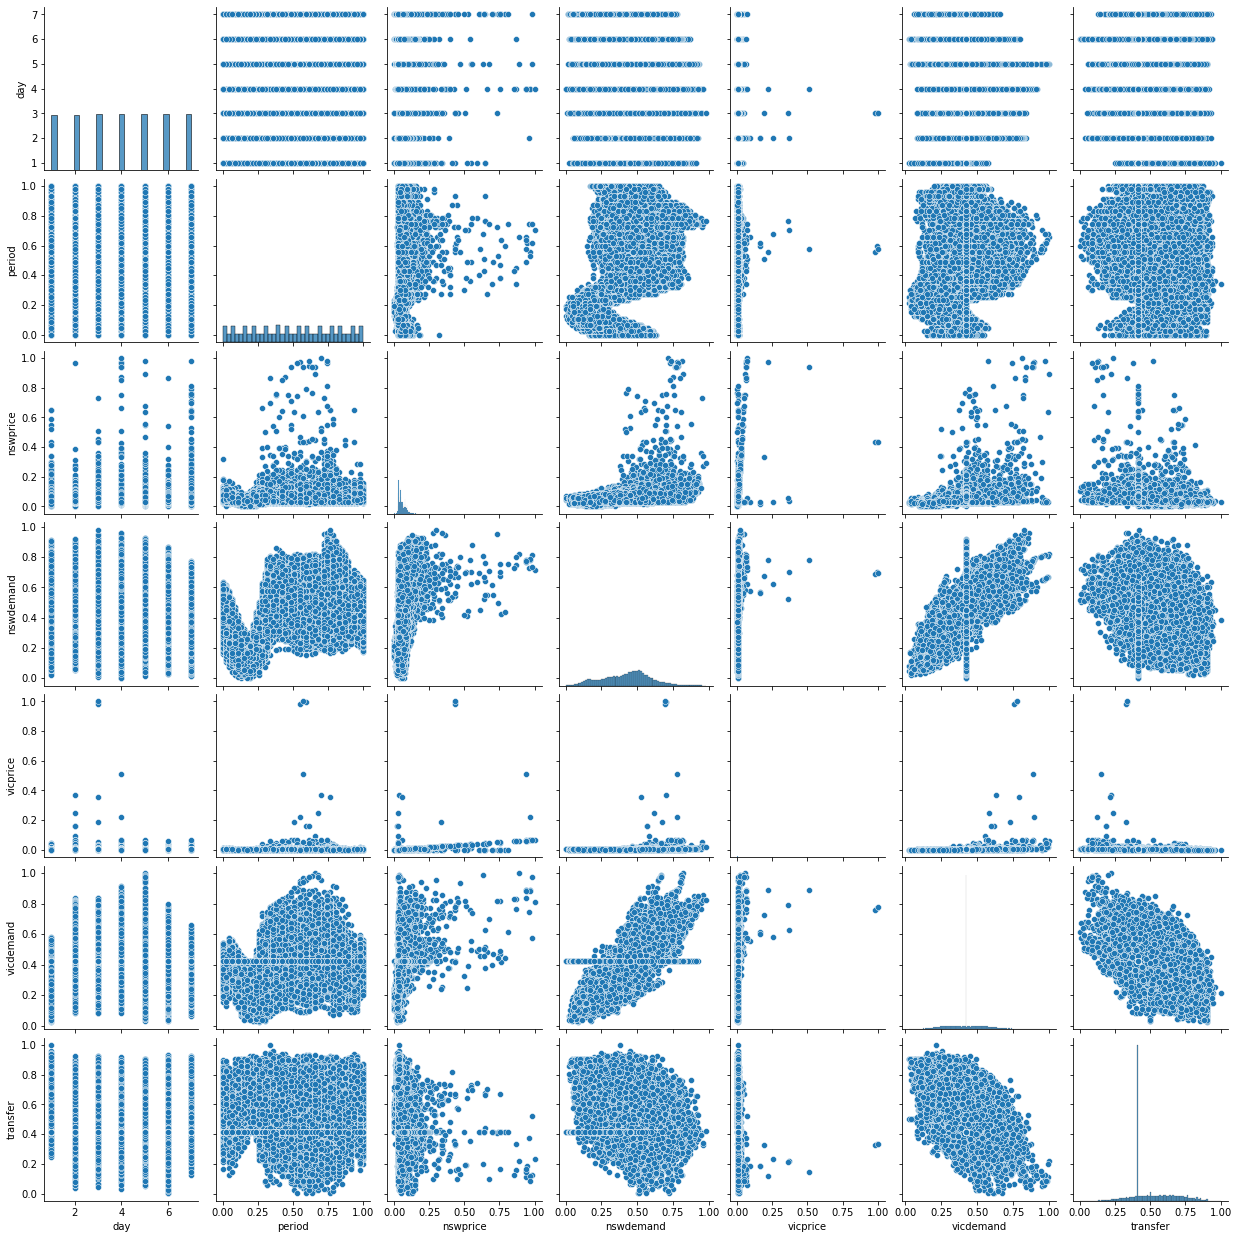

In [6]:
plt.show(sns.pairplot(X_train.iloc[:,]))

Прологорифмируем nswprice и ещё раз нарисуем pairplot.

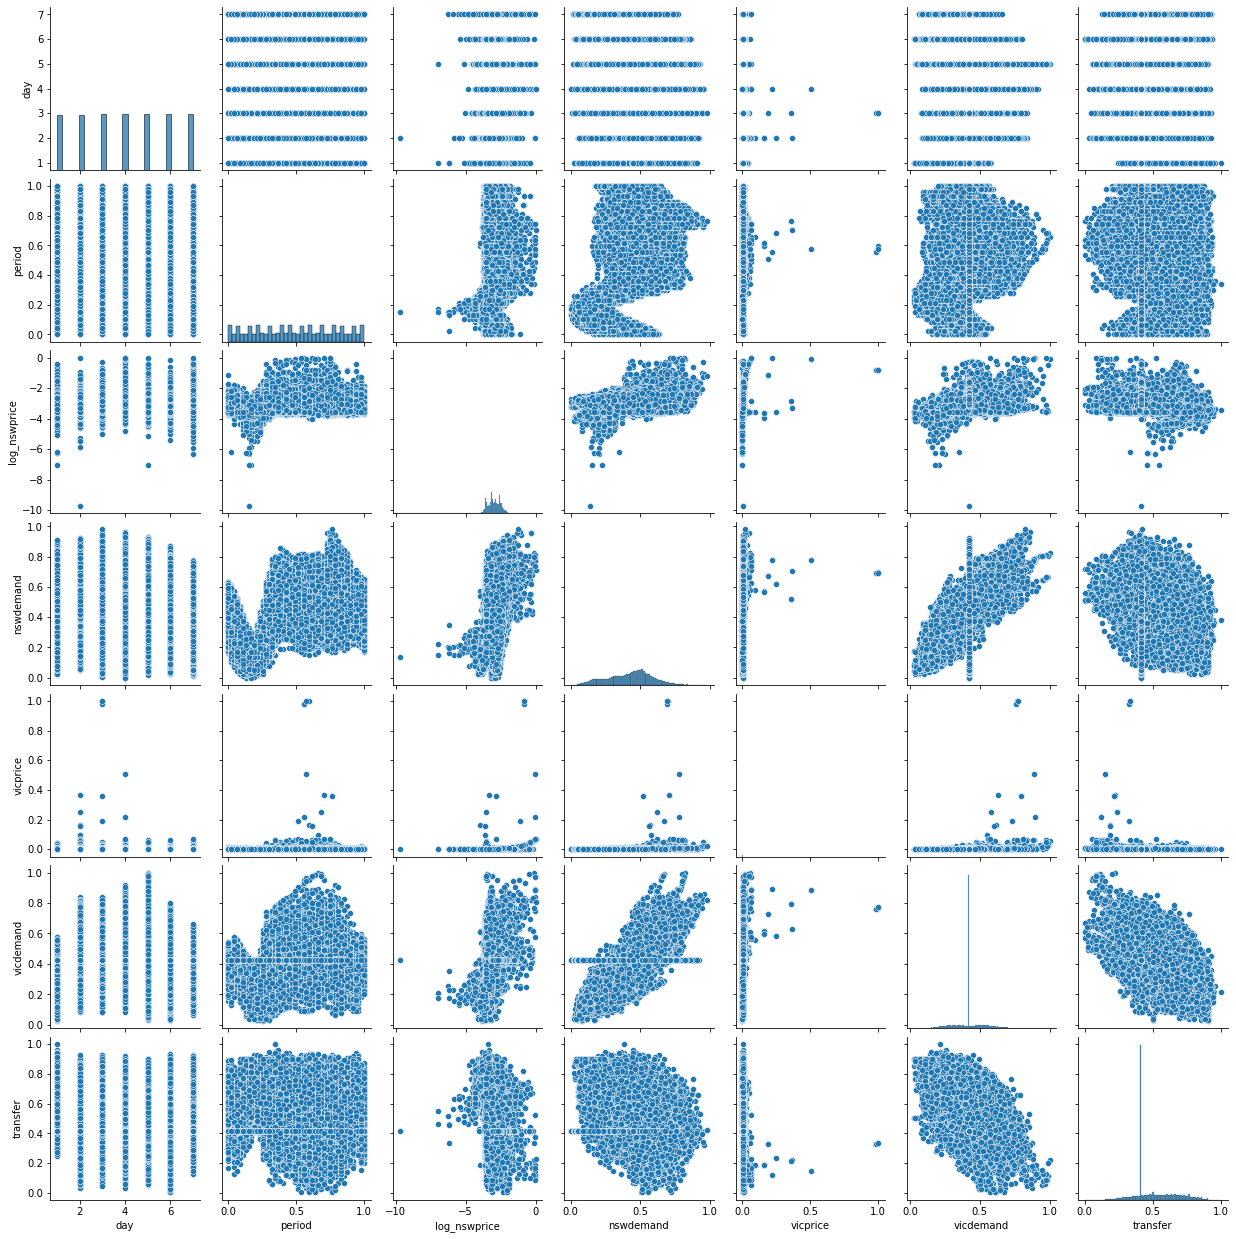

In [7]:
y_train = y_train[X_train.nswprice != 0]
X_train = X_train[X_train.nswprice != 0]
X_train.insert(2, 'log_nswprice', np.log(X_train['nswprice']))
X_train = X_train.drop('nswprice', axis=1)
plt.show(sns.pairplot(X_train.iloc[:,]))
y_test = y_test[X_test.nswprice != 0]
X_test = X_test[X_test.nswprice != 0]
X_test.insert(2, 'log_nswprice', np.log(X_test['nswprice']))
X_test = X_test.drop('nswprice', axis=1)

Преобразуем данные в массив numpy.

In [95]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.astype(int).to_numpy()
y_test = y_test.astype(int).to_numpy()

Обучим модель при фиксированных гиперпараметрах. И построим графики зависимости ошибки на train и validated выборках от номера эпохи.

In [149]:
mlp = MLPClassifier(hidden_layer_sizes=(150,), activation='relu',
                    solver='adam',
                    alpha=1e-4, verbose=False, learning_rate_init=.0001, max_iter=1, warm_start=True, early_stopping = False)
mlp_score1 = np.array([])
mlp_score2 = np.array([])
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, train_size=0.75, stratify=y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


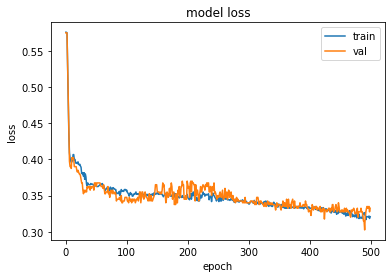

In [150]:
for i in range(1000):
    mlp.fit(X_train1, y_train1)
    mlp_score1 = np.append(mlp_score1, mlp.score(X_train1, y_train1))
    mlp_score2 = np.append(mlp_score2, mlp.score(X_train2, y_train2))
plt.figure()
plt.plot(1 - mlp_score1)
plt.plot(1 - mlp_score2)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper right')
plt.show()    

В определенный момент, примерно на 500 эпохе начинается переобучение и модель показывает результаты хуже на validated выборке, так как сильно подстроена под test.

Основные параметры:
hidden_layer_sizes -- количество нейронов на скрытом слое.
activation -- функция активации.
max_iter -- максимальное количество итераций.
solver -- метод оптимизации весов.

Будем варьировать эти параметры, выберем лучшую модель и проверим результаты на Test.

In [17]:
GRID = [
    {'estimator': [MLPClassifier()],
     'estimator__solver': ['adam', 'sgd'],
     'estimator__learning_rate_init': [0.1, 0.001, 0.0001],
     'estimator__max_iter': [200],
     'estimator__hidden_layer_sizes': [(1000,), (500,), (300,), (1500,)],
     'estimator__activation': ['logistic', 'relu', 'tanh'],
     'estimator__alpha': [1e-4, 1e-3],
     'estimator__early_stopping': [True, False]
     }
]

PIPELINE = Pipeline([('scaler', None), ('estimator', MLPClassifier())])

In [18]:
grid_search = GridSearchCV(estimator=PIPELINE, param_grid=GRID, 
                            scoring=make_scorer(accuracy_score),# average='macro'), 
                            n_jobs=-1, cv=5, refit=True, verbose=1, 
                            return_train_score=True)

In [19]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', None),
                                       ('estimator', MLPClassifier())]),
             n_jobs=-1,
             param_grid=[{'estimator': [MLPClassifier(hidden_layer_sizes=(1000,))],
                          'estimator__activation': ['logistic', 'relu', 'tanh'],
                          'estimator__alpha': [0.0001, 0.001],
                          'estimator__early_stopping': [True, False],
                          'estimator__hidden_layer_sizes': [(1000,), (500,),
                                                            (300,), (1500,)],
                          'estimator__learning_rate_init': [0.1, 0.001, 0.0001],
                          'estimator__max_iter': [200],
                          'estimator__solver': ['adam', 'sgd']}],
             return_train_score=True, scoring=make_scorer(accuracy_score),
             verbose=1)

In [20]:
print(grid_search.score(X_train, y_train))
print(grid_search.best_params_)

0.7922981366459627
{'estimator': MLPClassifier(hidden_layer_sizes=(1000,)), 'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__early_stopping': False, 'estimator__hidden_layer_sizes': (1000,), 'estimator__learning_rate_init': 0.001, 'estimator__max_iter': 200, 'estimator__solver': 'adam'}


In [21]:
print("Test set score: %f" % grid_search.score(X_test, y_test))

Test set score: 0.794325


Лучшие результаты показала модель, с 1000 нейронов на скрытом слое, функцией активации-- relu и методом оптимизации adam. 